In [1]:
#import packages
import numpy as np # linear algebra
import pandas as pd # data processing
import torch 
import torch.nn as nn
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import seaborn as sns

#load and print data
data = pd.read_csv('../input/synchronous-machine-dataset/SynchronousMachine.csv')
print(data.head())

   I_y    PF  e_PF   d_if    I_f
0  3.0  0.66  0.34  0.383  1.563
1  3.0  0.68  0.32  0.372  1.552
2  3.0  0.70  0.30  0.360  1.540
3  3.0  0.72  0.28  0.338  1.518
4  3.0  0.74  0.26  0.317  1.497


In [2]:
data.describe()

,I_y,PF,e_PF,d_if,I_f
count,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.499820,0.825296,0.174704,0.350659,1.530659
std,0.896024,0.103925,0.103925,0.180566,0.180566
min,3.000000,0.650000,0.000000,0.037000,1.217000
25%,3.700000,0.740000,0.080000,0.189000,1.369000
50%,4.500000,0.820000,0.180000,0.345000,1.525000
75%,5.300000,0.920000,0.260000,0.486000,1.666000
max,6.000000,1.000000,0.350000,0.769000,1.949000


<AxesSubplot:title={'center':'Plot of power factor and excitation current of synchronous machine'}>

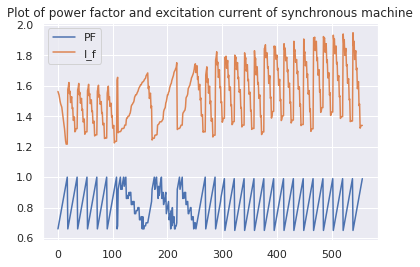

In [3]:
%matplotlib inline
sns.set()
data.plot(y=['PF', 'I_f'], title='Plot of power factor and excitation current of synchronous machine')

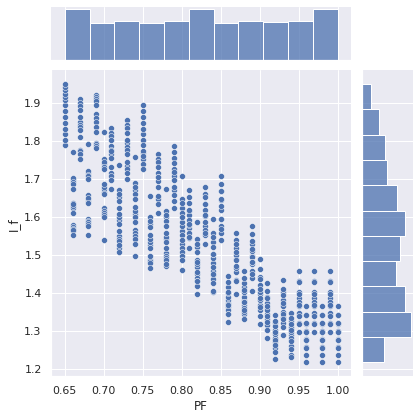

In [4]:
sns.jointplot(data=data,x='PF', y='I_f')

In [5]:
#split dataset to train and test sets
test_size = int(0.1 * len(data))
train_data = data[:-test_size]
test_data = data[-test_size:]

In [6]:
# normalize data
from sklearn import preprocessing

scaler = preprocessing.normalize(train_data, axis=0)

names = train_data.columns

scaled_df = pd.DataFrame(scaler, columns=names)
scaled_df.head()

,I_y,PF,e_PF,d_if,I_f
0,0.030286,0.035404,0.074776,0.044741,0.045597
1,0.030286,0.036477,0.070377,0.043456,0.045276
2,0.030286,0.037550,0.065979,0.042054,0.044926
3,0.030286,0.038623,0.061580,0.039484,0.044284
4,0.030286,0.039696,0.057182,0.037031,0.043671


In [7]:
train_data_normalized = torch.FloatTensor(scaled_df.values)

In [8]:
x = data['PF']
y = data['I_f']
x = torch.from_numpy(x.values.reshape(-1,1)).float()
y = torch.from_numpy(y.values.reshape(-1,1)).float()

In [9]:
class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)

Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


In [10]:
# Define Optimizer and Loss Function
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

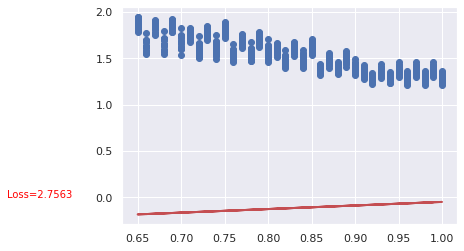

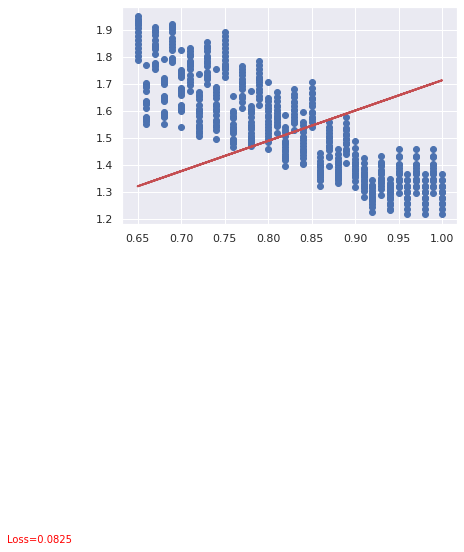

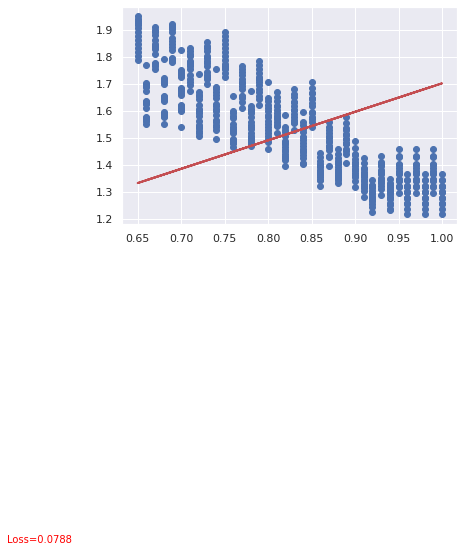

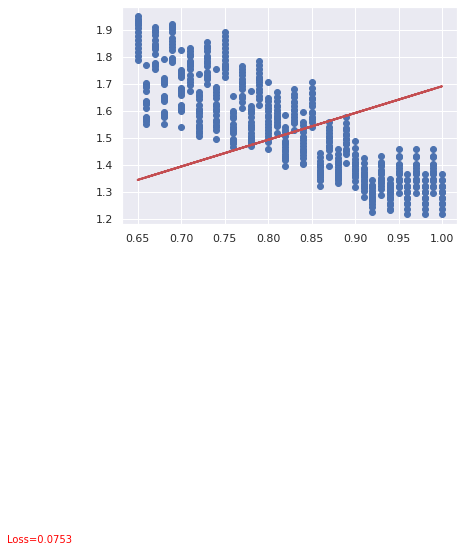

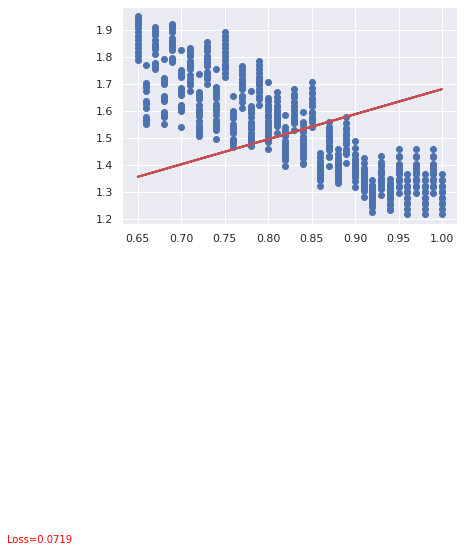

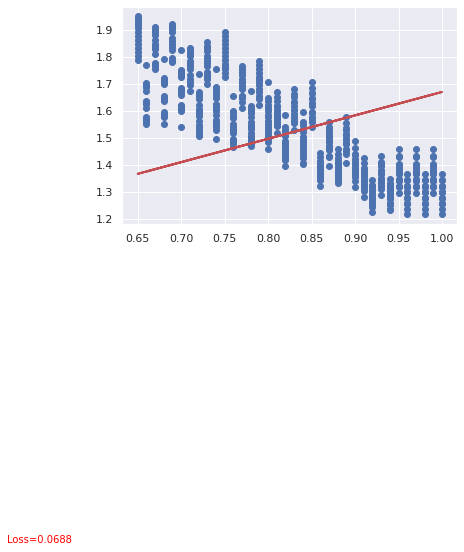

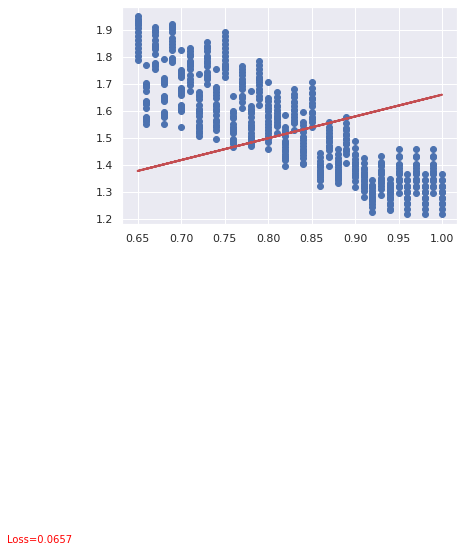

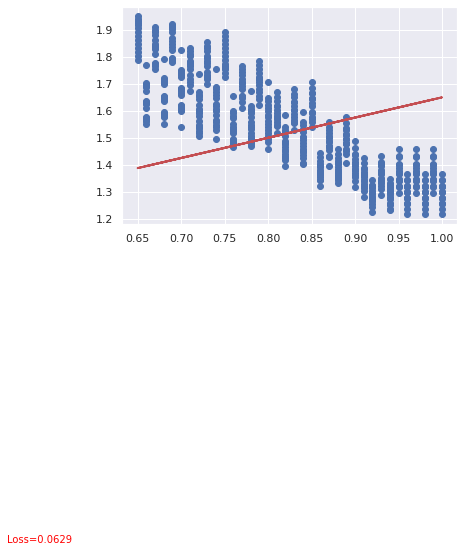

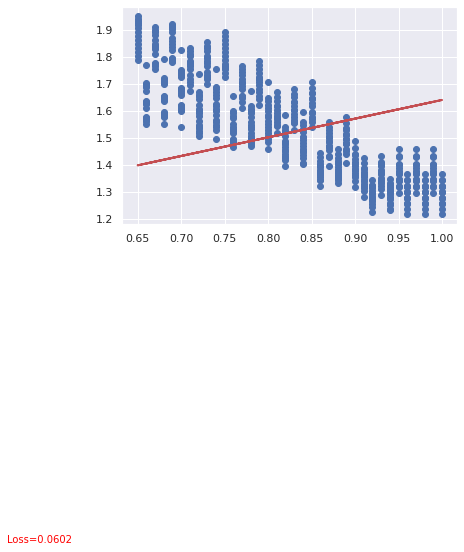

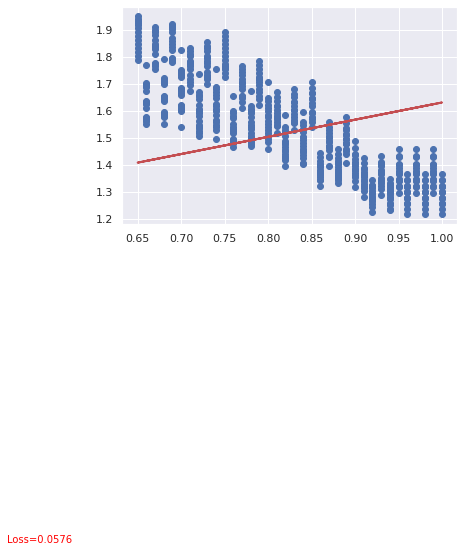

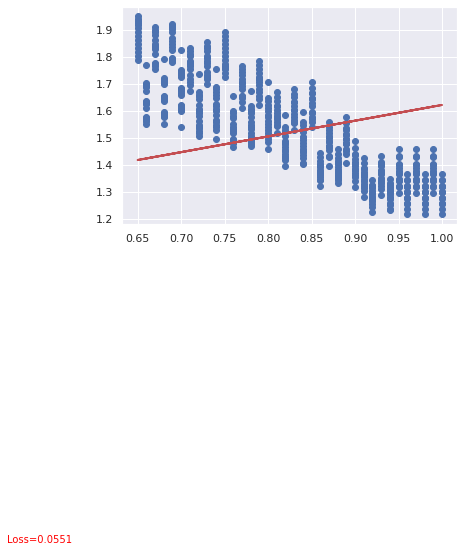

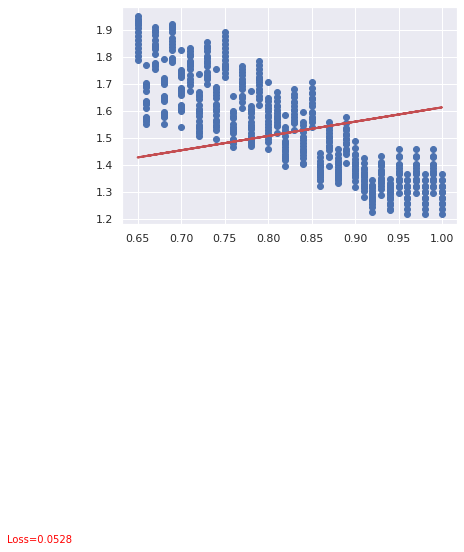

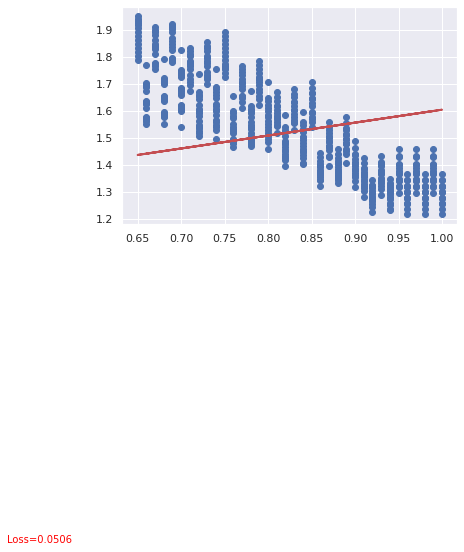

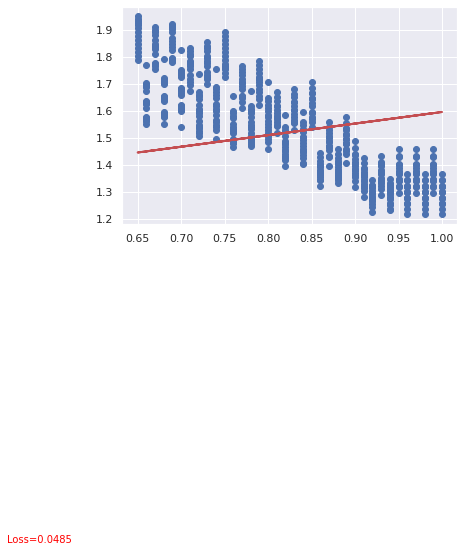

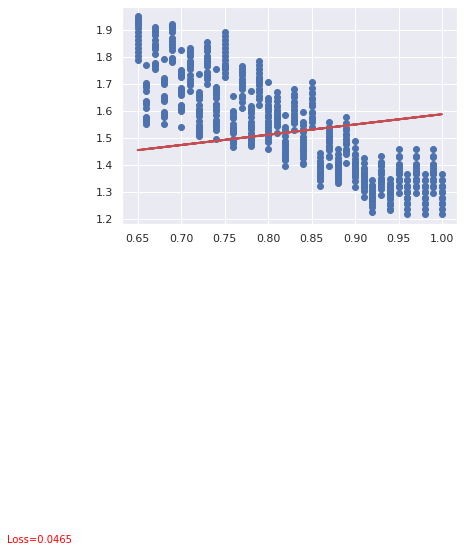

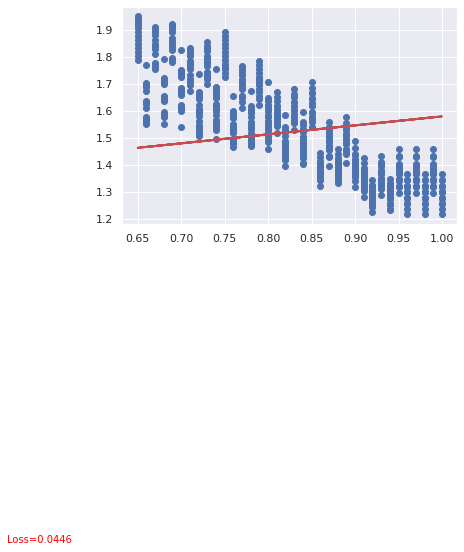

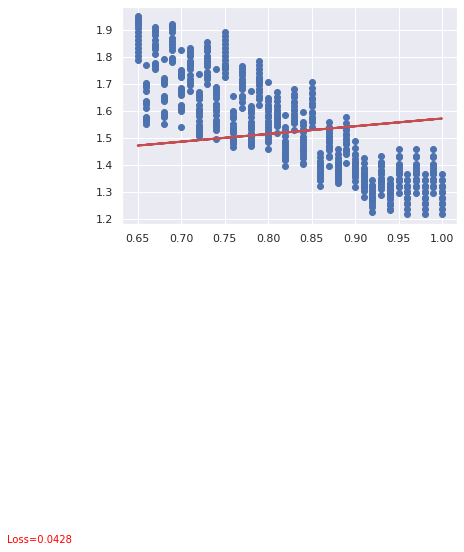

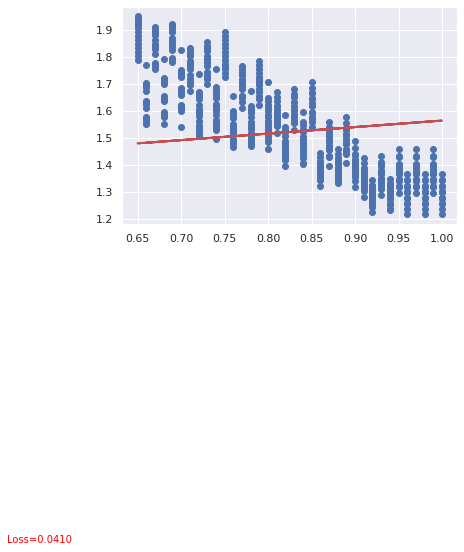

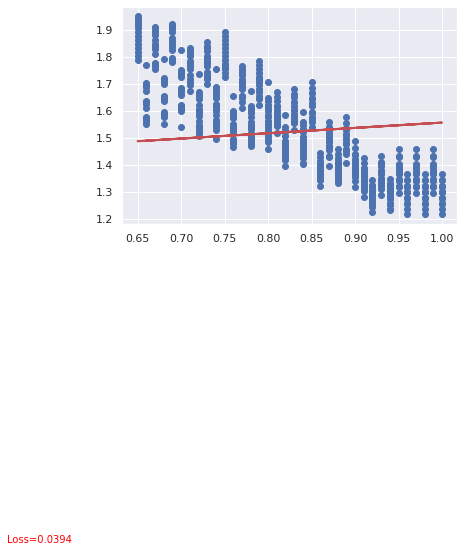

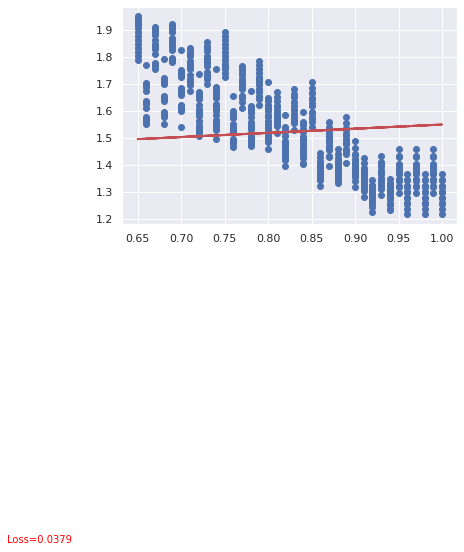

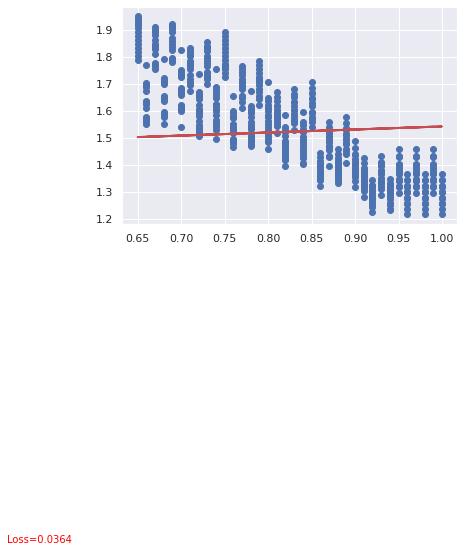

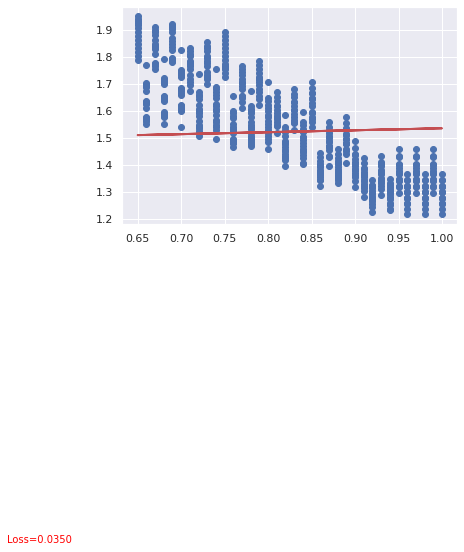

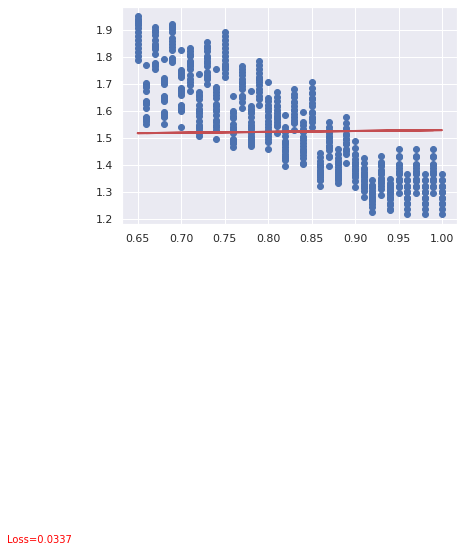

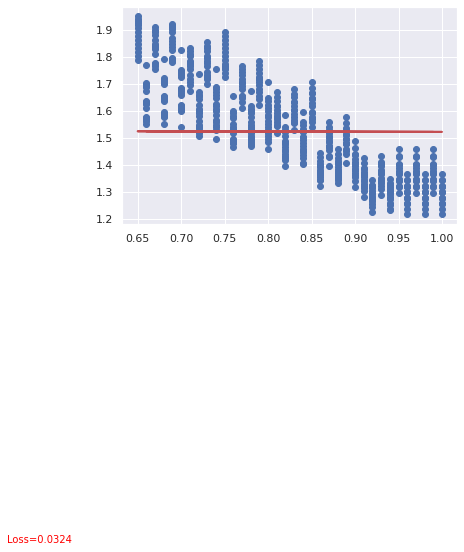

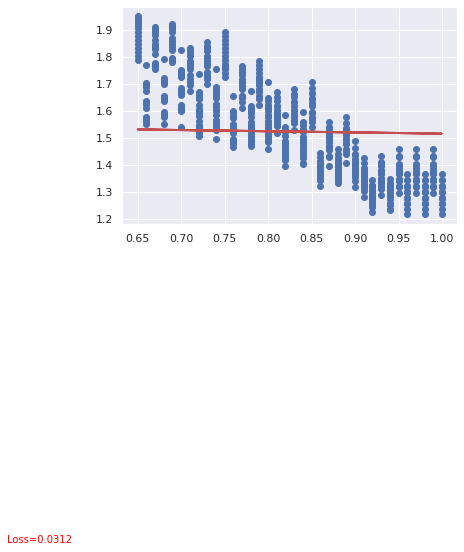

In [11]:
inputs = Variable(x)
outputs = Variable(y)
for i in range(250):
   prediction = net(inputs)
   loss = loss_func(prediction, outputs) 
   optimizer.zero_grad()
   loss.backward()        
   optimizer.step()       

   if i % 10 == 0:
       # plot and show learning process
       plt.cla()
       plt.scatter(x.data.numpy(), y.data.numpy())
       plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
       plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
       plt.pause(0.1)

plt.show()